In [6]:
# Set up libraries and backend
from qiskit.tools.jupyter import * 
from qiskit import IBMQ
from qiskit import assemble
import numpy as np
import matplotlib.pyplot as plt
from qiskit import pulse
from qiskit.pulse import Play
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit
import json

%config InlineBackend.figure_format = 'svg'
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

# Use for conversions later
GHz = 1.0e9
MHz = 1.0e6
kHz = 1.0e3
ms = 1.0e-3
us = 1.0e-6
ns = 1.0e-9
scale_factor = 1e-14

# Initialize qubit to |0> and retrieve backend frequencies
qubit = 0
dt = backend_config.dt
backend_defaults = backend.defaults()
qubit_props_dict = backend.properties().qubit_property(0)
rough_qubit_freq = qubit_props_dict['frequency'][0]
rough_cav_freq = backend_defaults.meas_freq_est[qubit]


# Define and configure measurement map (hardware constraint)
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in meas_map!"
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)
qubit_meas_group = backend_config.meas_map[meas_map_idx]
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qubit_meas_group)


# Define for convenience
def get_closest_multiple_of_16(num):
     return int(num + 8) - (int(num + 8) % 16)

# Functions to save data to and load data from external text files
def saveData(dataset, file):
    filehandler = open(file, 'w')
    json.dump(dataset, filehandler)
    filehandler.close()
    
def loadData(file):
    filehandler = open(file)
    data = json.load(filehandler)
    filehandler.close()
    return data

# Function for quickly extracting results from jobs
def get_job_data(job):
    result = job.result(timeout=120)
    sweep = []
    for i in range(len(result.results)):
        res = result.get_memory(i)*scale_factor
        sweep.append(res[qubit])
    return sweep

ibmqfactory.load_account:WARNING:2020-12-17 02:15:42,017: Credentials are already in use. The existing account in the session will be replaced.


In [7]:
# Get cavity frequency based on calibration experiment
cavity_data = loadData('CavityParameters.txt')
cav_freq_Hz = cavity_data['wc']
disp_Hz = cavity_data['X']
cav_freq_Hz_g = cav_freq_Hz + disp_Hz
cav_freq_GHz_g = cav_freq_Hz_g / GHz
print(cav_freq_Hz, cav_freq_Hz_g, rough_cav_freq)

qubit_data = loadData('QubitFrequency.txt')
qubit_freq_Hz = qubit_data['wq']
qubit_freq_GHz = qubit_freq_Hz / GHz
print(qubit_freq_GHz)

6993419623.685421 6993440719.492953 6993427855.0
4.974555289969859


In [8]:
acq_samp_us = 3.0
acq_samp = get_closest_multiple_of_16(acq_samp_us * us/dt)

acq_pulse = pulse.Acquire(acq_samp, pulse.AcquireChannel(qubit), 
                          mem_slot=pulse.MemorySlot(qubit)) # define acq pulse

In [9]:
chunking = 256
# Chunking Procedure that Abe told me to implement, splits GS pulse into rise + const pulses (width = 256 dt) + fall 
def composite_gaussian_square(channel, duration, amp, sigma, width):
    comp_pulse = pulse.Schedule()
    samples = pulse.GaussianSquare(duration, amp, sigma, width).get_waveform().samples
    risefall = get_closest_multiple_of_16((duration - width)//2)
    rise = pulse.Waveform(samples[:risefall])
    fall = pulse.Waveform(samples[risefall+width:])
    constant = pulse.Constant(chunking, amp)
    # remainder = pulse.Constant(width % chunking, amp)
    comp_pulse += pulse.Play(rise, channel)
    for i in range(width//chunking):
        comp_pulse += pulse.Play(constant, channel)
    # comp_pulse += pulse.Play(remainder, channel)
    comp_pulse += pulse.Play(fall, channel)
    return comp_pulse

In [10]:
# durations of cavity drive
dur_min_us = 0
dur_max_us = 35
num_samps = 35
durs_rise_us = np.linspace(dur_min_us, dur_max_us, num_samps, endpoint=False)
durs_rise = [get_closest_multiple_of_16(dur_us * us/dt) for dur_us in durs_rise_us]

# GS parameters
sigma_us = 0.01
sigma = get_closest_multiple_of_16(sigma_us * us/dt)
risefall_us = 0.02
risefall = get_closest_multiple_of_16(risefall_us * us/dt)

# sweep over pulse amplitude
amp_min = 0.0
amp_max = 1.0
num_amps = 11
amps = np.linspace(amp_min, amp_max, num_amps, endpoint=True)

# define width of measurement GS pulse in terms of its duration + risefall
meas_width = acq_samp - 2 * risefall

In [11]:
num_shots = 1024
gap_us = 0.1
gap = get_closest_multiple_of_16(gap_us * us/dt)

jobs = []
for amp in amps: 
    schedules = []
    # add meas pulse (during acq window) with same amp as drive; if drive amp = 0.0, meas amp = 0.1
    if (amp != 0.0):
        meas_pulse = pulse.GaussianSquare(acq_samp, amp, sigma, meas_width)
    else: 
        meas_pulse = pulse.GaussianSquare(acq_samp, 0.1, sigma, meas_width)
        
    # construct meas schedule
    meas_schedule = pulse.Schedule(name='Measurement schedule')
    meas_schedule += Play(meas_pulse, meas_chan)
    meas_schedule += acq_pulse
    
    for dur in durs_rise:
        width = dur - 2 * risefall
        schedule = pulse.Schedule(name="Ground state")
        
        # add chunked GS pulse 
        if (amp != 0.0 and dur != 0.0):
            square_pulse = composite_gaussian_square(meas_chan, dur, amp, sigma, width)
            schedule += square_pulse
            
        # measure barely after end of GS pulse
        schedule += meas_schedule << gap
        schedules.append(schedule)

    program = assemble(schedules, backend=backend, meas_level=1, meas_return='avg', shots=num_shots, schedule_los={meas_chan: cav_freq_Hz_g})
    job = backend.run(program)
    job_monitor(job)
    jobs.append(job)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [12]:
# collect data
sweeps = []
for job in jobs: 
    sweep = get_job_data(job)
    sweeps.append(sweep)

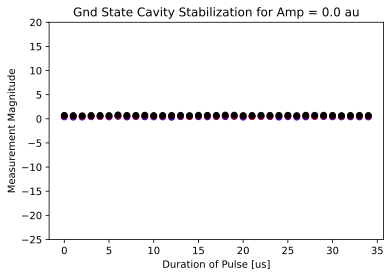

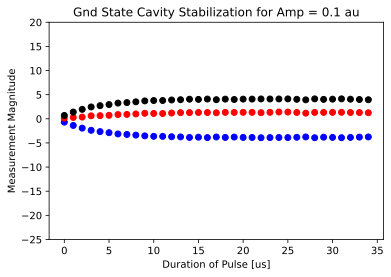

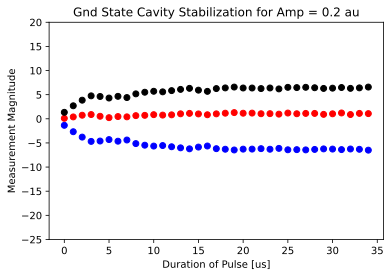

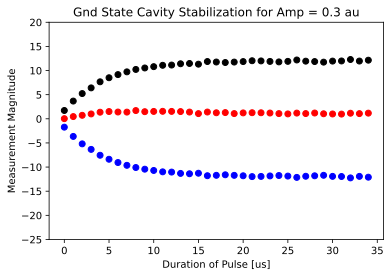

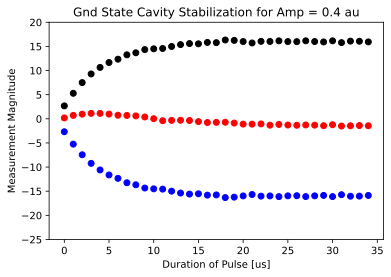

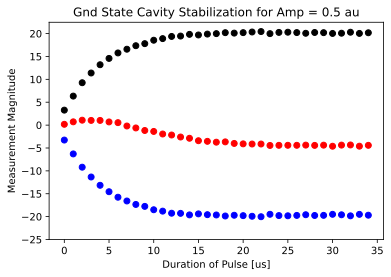

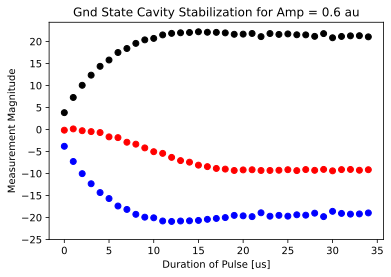

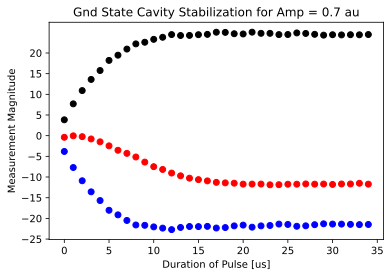

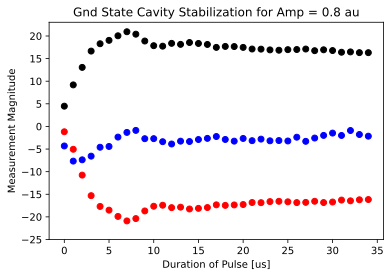

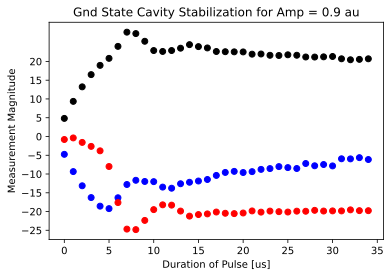

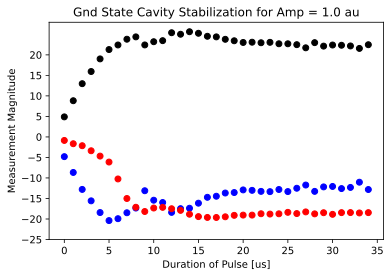

In [15]:
min_step = -25
max_step = 25
step_size = 5

# plot evolution of quadratures
for i in range(len(amps)): 
    plt.scatter(durs_rise_us, np.real(sweeps[i]), color='blue')
    plt.scatter(durs_rise_us, np.imag(sweeps[i]), color='red')
    plt.scatter(durs_rise_us, np.abs(sweeps[i]), color='black')
    plt.yticks(np.arange(min_step, max_step, step_size))
    plt.xlabel("Duration of Pulse [us]")
    plt.ylabel("Measurement Magnitude")
    plt.title(f"Gnd State Cavity Stabilization for Amp = {str(round(amps[i], 1))} au")
    plt.show()

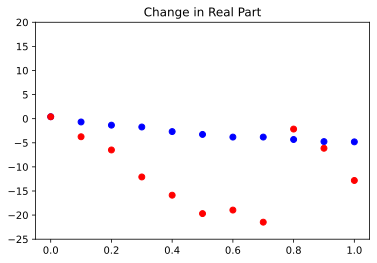

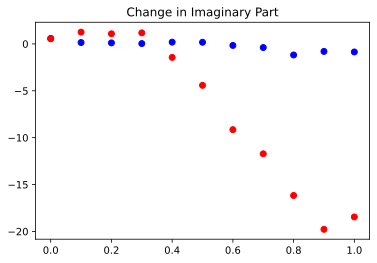

In [17]:
# more or less always stable by 20 us
# plot displacement in quadratures

initial_quads = []
final_quads = []
for sweep in sweeps:
    initial_quads.append(sweep[0])
    final_quads.append(sweep[-1])

plt.scatter(amps, np.real(initial_quads), color='blue')
plt.scatter(amps, np.real(final_quads), color='red')
plt.yticks(np.arange(min_step, max_step, step_size))
plt.title("Change in Real Part")
plt.show()

plt.scatter(amps, np.imag(initial_quads), color='blue')
plt.scatter(amps, np.imag(final_quads), color='red')
plt.title("Change in Imaginary Part")
plt.show()